### Configuracion

In [1]:
import numpy as np
import cmath
import math
import matplotlib.pyplot as plt

from skimage.draw import rectangle, line
from skimage.transform import rotate
import skimage.io as io

import os

### Ejemplo de Numeros Imaginarios

In [2]:
x = 5
y = 3

# creamos a z = x + iy
z = x + 1j * y

# imprimimos la parte Real e Imaginaria. T
print("La parte real del numero es:", z.real)
print("La parte imaginaria del numero es:", z.imag)

print()

# Numpy tambien acepta operar con numeros complejos
arregloReales = np.random.randint(size=4,low=-10, high=10)
arregloImaginarios = np.random.randint(size=4,low=-10, high=10) * 1j
arregloComplejo = arregloReales + arregloImaginarios

print("Arreglo Complejo")
print(arregloComplejo)

print("Parte Real")
print(np.real(arregloComplejo))

print("Parte Imaginaria")
print(np.imag(arregloComplejo))


La parte real del numero es: 5.0
La parte imaginaria del numero es: 3.0

Arreglo Complejo
[-4.+7.j  6.-7.j  6.-7.j -3.-1.j]
Parte Real
[-4.  6.  6. -3.]
Parte Imaginaria
[ 7. -7. -7. -1.]


### 1. Graficar las bases de la Transformada de Fourier de dimensión 8 en 1-D y de dimensión 8 × 8 en 2-D

/tmp/ipykernel_1330727/3917493941.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


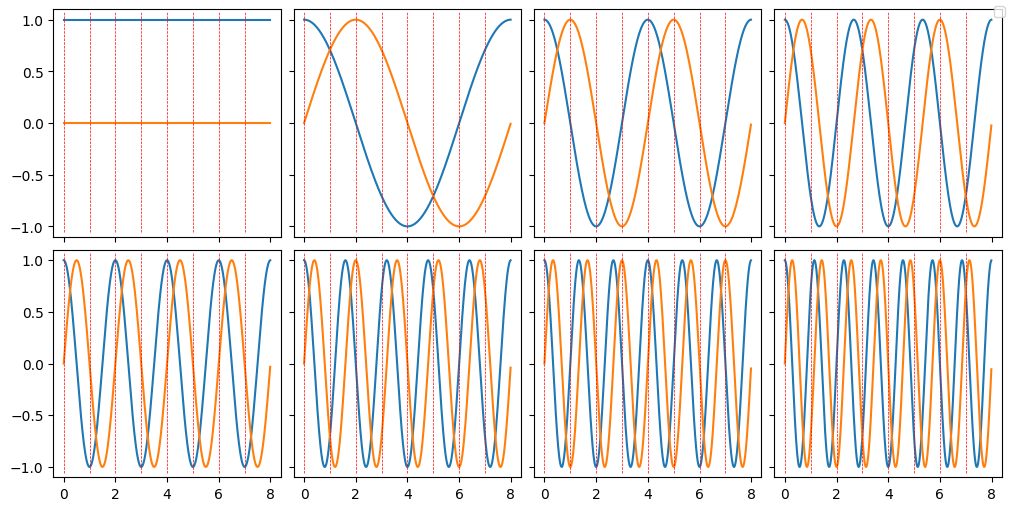

In [3]:
#Numero de Muestras de la senal
N = 8

#Opciones para graficar
#Velocidad del sampleo
sampleoRate = 1/100
#Cuantos sampleos se haran
sampleoGrafico = int(N/sampleoRate)

#Inicializamos un arreglo para guardar cada base y su evolucion
bases1D = np.zeros((N,sampleoGrafico)) * 1j

#Recorremos cada frecuencia
for frecuencia in range(0,N):
  for i in range(sampleoGrafico):
    # Por cada vemos como avanza en el tiempo para luego plotearla
    t = i*sampleoRate
    frecuenciaAngular = ((2*np.pi)/N) * (frecuencia)
    # Calculamos la parte real e imaginaria de la base.
    bases1D[frecuencia][i] = np.exp(1j * frecuenciaAngular * t)

fig, axes = plt.subplots(2,4, figsize=(10, 5),sharex=True, sharey=True, layout="constrained")
for base in range(N):
  axes[base//4][base%4].plot(np.arange(0,sampleoGrafico*sampleoRate,sampleoRate),np.real(bases1D[base]))
  axes[base//4][base%4].plot(np.arange(0,sampleoGrafico*sampleoRate,sampleoRate),np.imag(bases1D[base]))
  for sample in range(N):
    # Mostramos que valor tiene cada base al momento del sampleo de las N.
    axes[base//4][base%4].axvline(x = sample, ymin=0.02, ymax=0.99  , color = 'r', ls='--', lw=0.5)

fig.legend()


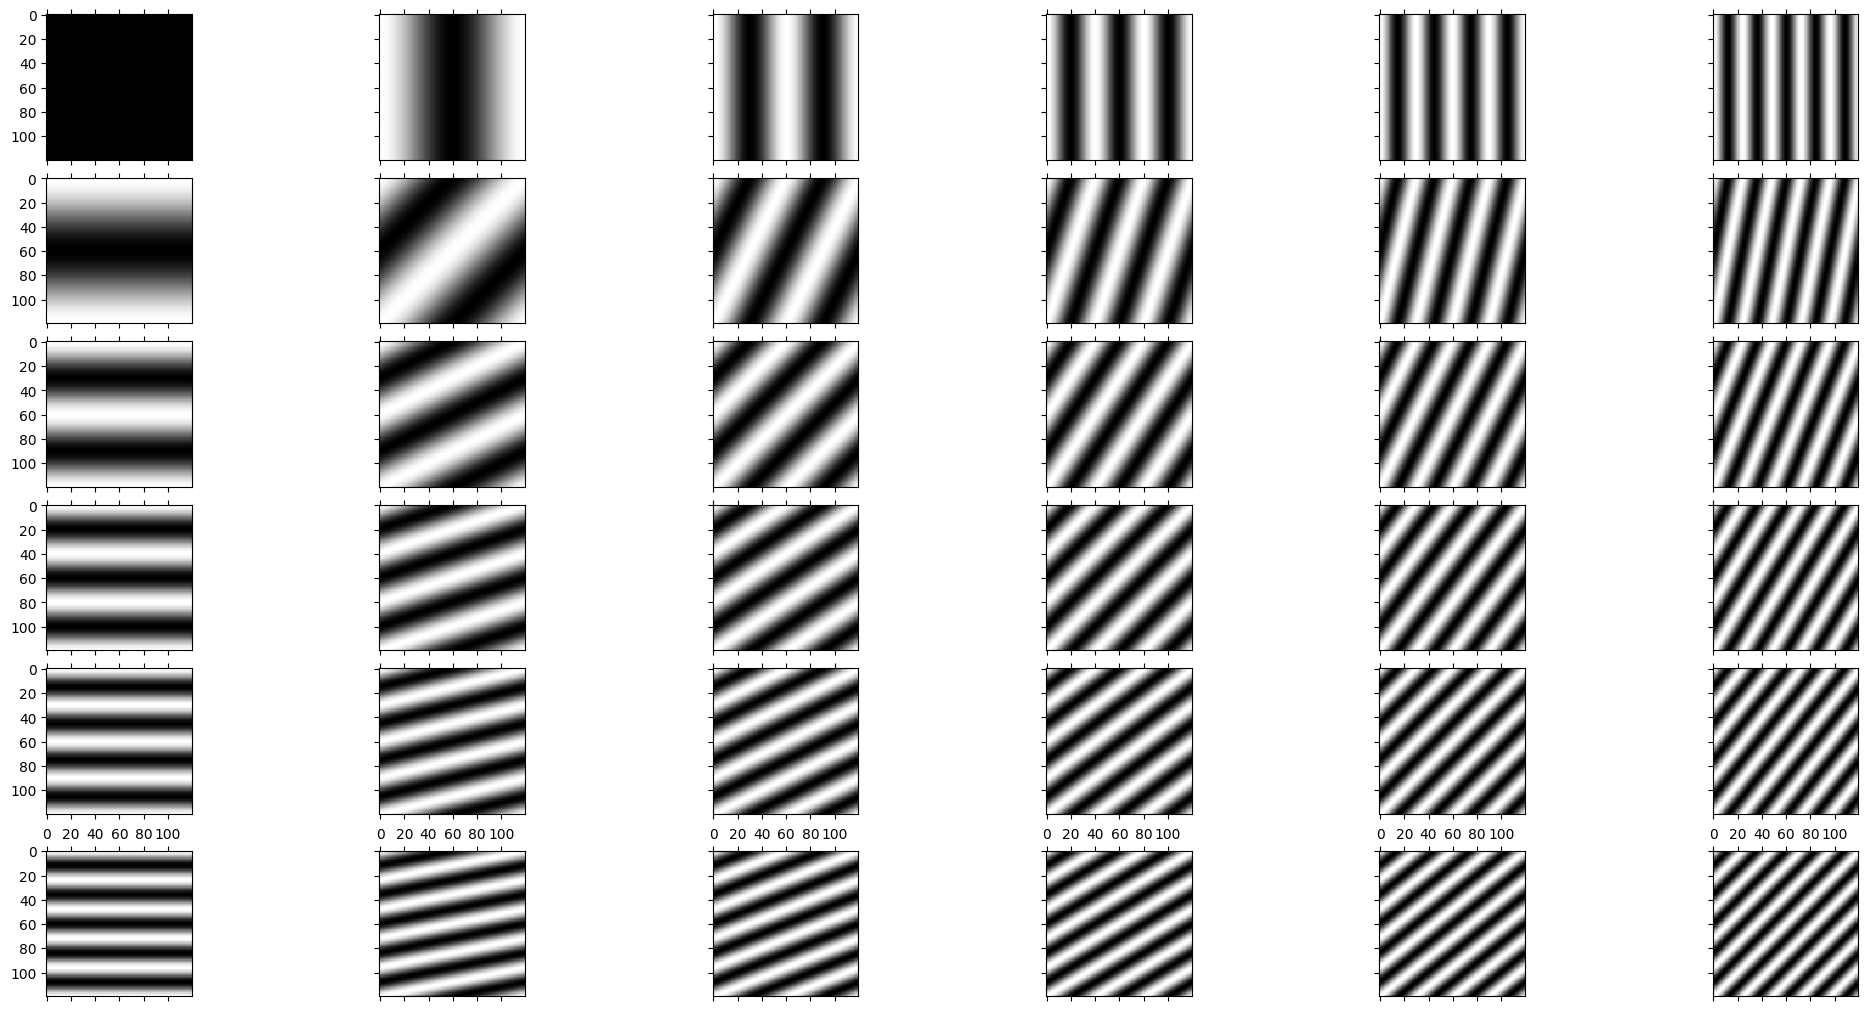

In [4]:
# Ploteo de las bases en 2D
#Definimos el sampleo horizontal y vertical
N = 6
M = 6
#Configuramos los valores para graficar
sampleoRate = 1/20
sampleoGrafico = int(N/sampleoRate)

#Ahora nuestras bases seran matrices, no arreglos
bases2D = np.zeros((N,M,sampleoGrafico,sampleoGrafico)) * 1j

for frecuenciaX in range(0,N):
  for frecuenciaY in range(0,M):
    for intervaloX in range(sampleoGrafico):
      for intervaloY in range(sampleoGrafico):
        # Calculamos como la base avanza en el tiempo y guardamos su valor
        tX = intervaloX*sampleoRate
        tY = intervaloY*sampleoRate
        frecuenciaAngularX = (2*np.pi*frecuenciaX /N)
        frecuenciaAngularY = (2*np.pi*frecuenciaY /M)
        angulo = frecuenciaAngularX * tX + frecuenciaAngularY * tY
        bases2D[frecuenciaX][frecuenciaY][intervaloX][intervaloY] = np.exp(angulo * 1j)

fig, axes = plt.subplots(N,M, figsize=(20, 10),sharex=True, sharey=True, layout="constrained")
for baseX in range(N):
  for baseY in range(M):
    axes[baseX][baseY].matshow(np.real(bases2D[baseX][baseY]),cmap=plt.cm.gray)


### Implementar la DFT en 1D

Visualizacion interactiva entre la relacion de los numeros complejos y los caminos circulares: [betterexplained.com](https://betterexplained.com/examples/fourier/)

In [13]:
"""La funcion debe devolver un arreglo con la magnitud de la frecuencia y tambien su Fase"""
def DFT_1D(senal):
  F = np.zeros(senal.size, dtype=np.complex128)
  N = senal.shape[0]
  # Realizamos el producto interno entre cada base y la senal original
  bases = np.zeros(senal.size, dtype=np.complex128)
  
  for k in range(N):
    val = 0
    for i in range(N):
      bases[i] = (np.exp(-2*np.pi*1j*(i*k)/N))
    val = np.dot(senal,bases)/np.sqrt(N)
    F[k] = val

  Fmagnitud = np.zeros(senal.size)
  Fangulo = np.zeros(senal.size)
  # Calculamas el modulo y la fase del numero complejo
  for k in range(N):
    Fmagnitud[k] = np.linalg.norm(F[k])
    Fangulo[k] = np.angle(F[k])

  
  return Fmagnitud,Fangulo

def IDFT_1D(senalModulo, senalFase):
  # Realizamos la sumatoria entre cada base y su proyeccion
  N = senalModulo.size
  f = np.zeros(senalModulo.size)
  for k in range(N):
    val = 0
    for n in range(N):
      val = val + senalModulo[n]*np.exp(1j*senalFase[n])*np.exp(2*np.pi*1j*(n*k)/N)
    val = val / np.sqrt(N)
    f[k] = val.real
  # obteniendo la imagen original
  return f

In [14]:
def filtrado_frecuencias(senalModulo, frec="alta"):
  minimo = np.min(senalModulo)
  maximo = np.max(senalModulo)
  tamfrac = (maximo-minimo)/3
  divalta = minimo + tamfrac*2
  divbaja = minimo + tamfrac

  senalfiltrada = np.zeros(senalModulo.size, dtype=float)
  for i in range(senalModulo.size):
    if(frec=="alta" and senalModulo[i]<divalta):
      senalfiltrada[i] = senalModulo[i]
    if(frec=="inter" and senalModulo[i]>divalta and senalModulo[i]<divbaja):
      senalfiltrada[i] = senalModulo[i]
    if(frec=="baja" and senalModulo[i]>divbaja):
      senalfiltrada[i] = senalModulo[i]
  return senalfiltrada

In [15]:
senal = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0])
senalModulo, senalFase = DFT_1D(senal)
senalotravez = IDFT_1D(senalModulo,senalFase)
print(senalModulo)
print(senalFase)
print(senal)
print(senalotravez)

[1.33333333 0.95979508 0.17736296 0.33333333 0.21756788 0.21756788
 0.33333333 0.17736296 0.95979508]
[ 0.00000000e+00 -1.04719755e+00 -2.09439510e+00 -1.11022302e-16
 -1.04719755e+00  1.04719755e+00 -3.33066907e-16  2.09439510e+00
  1.04719755e+00]
[1 1 1 1 0 0 0 0 0]
[ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
 -4.34837351e-16  1.11022302e-16  3.33066907e-16  4.07081776e-16
  7.77156117e-16]


In [16]:
def filtrado_frecuencias2(senalModulo, frec="alta"):
  lord = np.sort(senalModulo)
  tam = senalModulo.size/3
  senalfiltrada = np.zeros(senalModulo.size)
  lb = int(np.round(tam))
  ub = int(np.round(2*tam))
  if (frec=="alta"):
    lim = lord[ub]
    for i in range(senalModulo.size):
      if(senalModulo[i]<=lim):
        senalfiltrada[i] = senalModulo[i]
    
  if(frec=="inter"):
    lim1 = lord[lb]
    lim2 = lord[ub]
    for i in range(senalModulo.size):
      if(senalModulo[i]<=lim1 or senalModulo[i]>=lim2):
        senalfiltrada[i] = senalModulo[i]
    
  if(frec=="baja"):
    lim = lord[lb]
    for i in range(senalModulo.size):
      if(senalModulo[i]>=lim):
        senalfiltrada[i] = senalModulo[i]
  return senalfiltrada
  

[0.         0.         0.25       0.37415144 0.25       0.16704466
 0.25       0.04972809 0.25       0.04972809 0.25       0.16704466
 0.25       0.         0.25       0.        ]
[2.25       1.25683487 0.         0.37415144 0.         0.16704466
 0.         0.04972809 0.         0.04972809 0.25       0.16704466
 0.25       0.37415144 0.         1.25683487]
[2.25       1.25683487 0.25       0.37415144 0.25       0.
 0.25       0.         0.25       0.         0.25       0.
 0.         0.37415144 0.25       1.25683487]


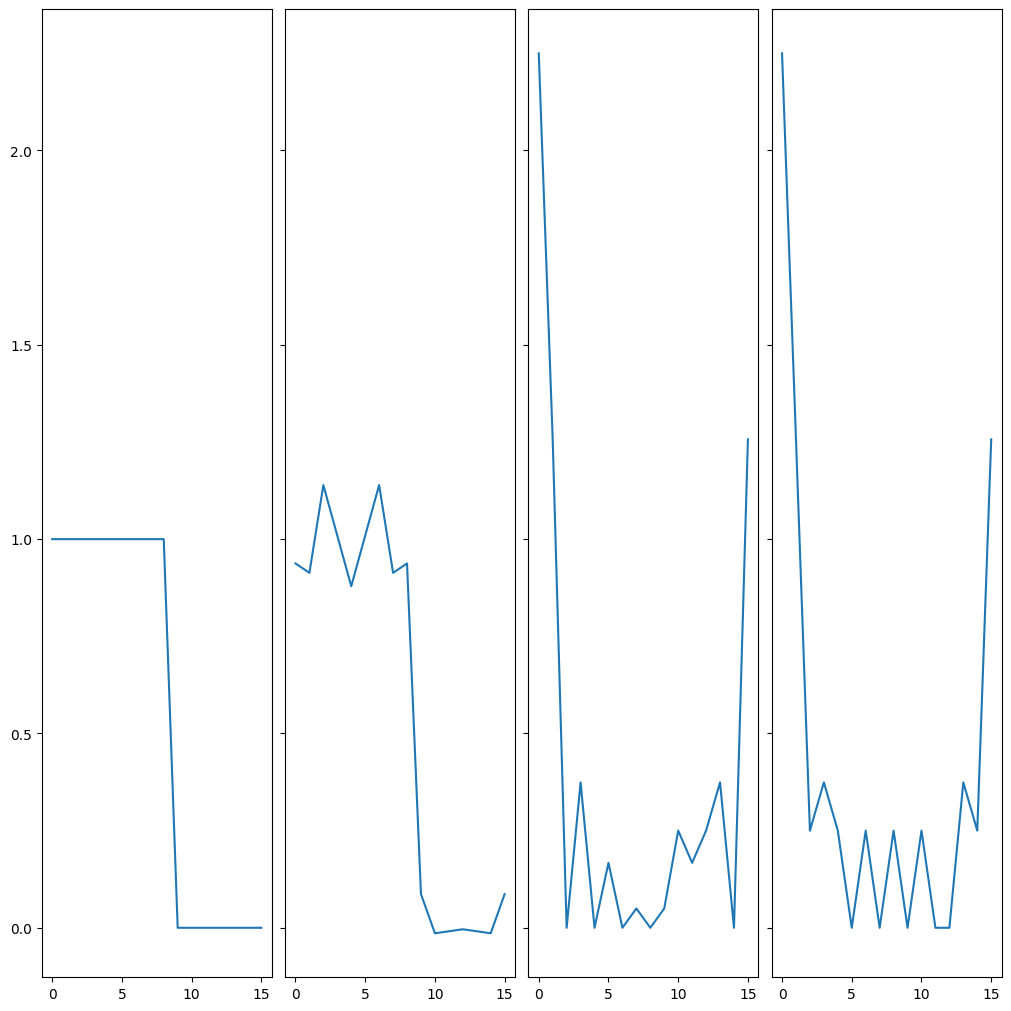

In [17]:
senal = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])
senalModulo, senalFase = DFT_1D(senal)
## Suprimir Frecuencias Altas
senalModuloSinAltas = filtrado_frecuencias2(senalModulo,"alta")
senalSinAltas = IDFT_1D(senalModuloSinAltas,senalFase)
print(senalModuloSinAltas)

## Suprimir Frecuencias Intermedias
senalModuloSinIntermedias = filtrado_frecuencias2(senalModulo,"inter")
senalSinAltas = IDFT_1D(senalModuloSinIntermedias,senalFase)
print(senalModuloSinIntermedias)

## Suprimir Frecuencias Bajas
senalModuloSinBajas = filtrado_frecuencias2(senalModulo,"baja")
senalSinAltas = IDFT_1D(senalModuloSinBajas,senalFase)
print(senalModuloSinBajas)


fig, axes = plt.subplots(1, 4, figsize=(10, 10),sharex=True, sharey=True, layout="constrained")
axes[0].plot(range(senal.shape[0]), senal)
axes[1].plot(range(senal.shape[0]), senalSinAltas)
axes[2].plot(range(senal.shape[0]), senalModuloSinIntermedias)
axes[3].plot(range(senal.shape[0]), senalModuloSinBajas)
plt.show()


## Generar 10 imágenes y hacer la DFT y la IDFT de cada una









In [18]:
"""
Recuerden que DFT devuelve numeros complejos, en este caso querremos devolver 2
matrices, la primera contendra la magnitud del numero en la frecuencia y la segunda
contendra su angulo
"""
# def DFT_2D(imagen):
#   F = np.zeros(senal.shape)
#   N = senal.shape[0]
#   # Realizamos el producto interno entre cada base y la senal original
#   bases = []
#   for k in range(N):
#     for l in range(N):
#       val = 0
#       for n in range(N):
#         for m in range(N):
#           val = val + senal[n][m]*np.exp(-2*np.pi*1j*(m*k+n*l))
#       val = val / N
#       F[k,l] = val

#   Fmagnitud = np.zeros(senal.shape)
#   Fangulo = np.zeros(senal.shape)
#   # Calculamas el modulo y la fase del numero complejo
#   for k in range(N):
#     for l in range(N):
#       Fmagnitud = F[k,l]
#   pass

# def IDFT_2D(frecuenciasMagnitud, frecuenciasAngulo):
#   res = np.zeros(frecuenciasMagnitud.shape)
#   X = frecuenciasMagnitud.shape[0]
#   Y = frecuenciasMagnitud.shape[1]
#   for x in range(X):
#     for y in range(Y):
#         sum = 0
#         for k in range(X):
#           for l in range(Y):
#             imaginario = frecuenciasMagnitud[k,l] * np.exp(1j * frecuenciasAngulo[k,l])
#             sum = sum + (imaginario * np.exp((2 * np.pi * 1j *(k*x + l*y))/X))
#         res[x,y] = sum/X




def DFT_2D(imagen):
  F = np.zeros(imagen.shape,dtype=np.complex128)
  bases = np.zeros(imagen.shape,dtype=np.complex128)
  
  M = imagen.shape[0]
  N = imagen.shape[1]
  for u in range(F.shape[0]):
    for v in range(F.shape[1]):
      #value_F = 0
      value_F = np.zeros(imagen.shape)
      for x in range(imagen.shape[0]):
        for y in range(imagen.shape[1]):
          #value_F += imagen[x][y] * np.exp(-2*np.pi * 1j * (u * x/M  +  v * y/N) )
          bases[x][y] = np.exp(-2*np.pi * 1j * (u * x/M  +  v * y/N))
      #F[u][v] = value_F
      F[u][v] = np.sum(np.multiply(bases,imagen))


  F_Magnitud = np.zeros(F.shape)
  F_Angulo = np.zeros(F.shape)

  for u in range(F.shape[0]):
    for v in range(F.shape[1]):
      F_Magnitud[u][v] = np.linalg.norm(F[u][v])
      F_Angulo[u][v] = np.angle(F[u][v])
  return F_Magnitud,F_Angulo



def IDFT_2D(frecuenciasMagnitud, frecuenciasAngulo):
  f = np.zeros(frecuenciasMagnitud.shape)

  #Reconstruyo F
  F = np.multiply(frecuenciasMagnitud,np.exp(1j * frecuenciasAngulo))
  bases = np.zeros(frecuenciasMagnitud.shape,dtype=np.complex128)

  M = f.shape[0]
  N = f.shape[1]


  for x in range(M):
    for y in range(N):
      value_f = np.zeros(f.shape)
      
      for u in range(M):
        for v in range(N):
          bases[u][v] = np.exp(2*np.pi*1j * (u*x/M + y*v/N))
      
      f[x][y] = np.sum(np.multiply(F,bases)) / (M*N)
  
  return f

### Probamos nuestra implementación vs la de numpy

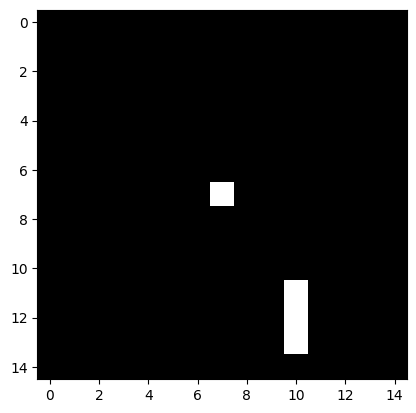

In [22]:
TestSize = 15
testImg = np.zeros((TestSize,TestSize),dtype=float)
testImg[TestSize//2][TestSize//2] = 1
testImg[11][10] = 1
testImg[12][10] = 1
testImg[13][10] = 1
plt.imshow(testImg,cmap=plt.cm.gray)


/tmp/ipykernel_1330727/1730748524.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  f[x][y] = np.sum(np.multiply(F,bases)) / (M*N)


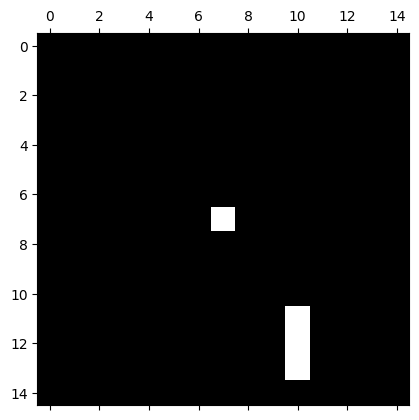

In [23]:
testImg_mag,testImg_angle = DFT_2D(testImg)
testImgReconstruida = np.multiply(testImg_mag,np.exp(1j * testImg_angle))
newTestImg = IDFT_2D(testImg_mag,testImg_angle)
plt.matshow(newTestImg,cmap=plt.cm.gray)

In [24]:
dftP = np.fft.fft2(testImg)
dftP_mag = np.zeros(dftP.shape)
dftP_angle = np.zeros(dftP.shape)
for u in range(dftP.shape[0]):
  for v in range(dftP.shape[1]):
    dftP_mag[u][v] = np.linalg.norm(dftP[u][v])
    dftP_angle[u][v] = np.angle(dftP[u][v])

#Máxima diferencia, producto de errores numéricos
print(np.max(np.abs(dftP_mag-testImg_mag)))
print(np.max(np.abs(dftP_angle-testImg_angle)))

2.220446049250313e-14
6.283185307179585


In [26]:
#Indicamos el tamano de la imagen
dimensionImagen = 100

#### Cuadrado transladado ####
#Creamos una imagen vacia
imagenCuadradoTransladado = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
#inciamos donde iniciara el cuadrado
start = (20,40)
#Dado el tamano de los lados y su punto de inicio, nos devuelve las filas y columnas que ocupara
rr, cc = rectangle(start, extent=(20, 20))
#Pintamos esas celdas de blanco
imagenCuadradoTransladado[rr, cc] = 255

def mostrarDFTyIDFT(imagenOriginal):
  ## Aplicar DFS a la imagen
  dfsImagenMagnitud, dfsImagenPhase = DFT_2D(imagenOriginal)
  imagenReconstruida = IDFT_2D(dfsImagenMagnitud, dfsImagenPhase)

  fig, axes = plt.subplots(2,2, figsize=(10, 10),sharex=True, sharey=True, layout="constrained")
  axes[0][0].matshow(imagenCuadradoTransladado, cmap=plt.cm.gray)
  axes[0][1].matshow(dfsImagenMagnitud, cmap=plt.cm.gray)
  axes[0][2].matshow(dfsImagenPhase, cmap=plt.cm.gray)
  axes[0][3].matshow(imagenReconstruida, cmap=plt.cm.gray)

mostrarDFTyIDFT(imagenCuadradoTransladado)

#### Cuadrado transladado ####
imagenCuadradoCentral = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenCuadradoCentral)

#### Rectangulo ####
imagenRectangulo = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenRectangulo)

#### 2 Rectangulos ####
imagenDosRectangulo = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenDosRectangulo)

#### Linea Vertical ####
imagenLineaVertical = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
#indicamos el punto de inicio y el final de la linea
rr, cc = line(40, 20, 40, 90)
imagenLineaVertical[rr, cc] = 255

mostrarDFTyIDFT(imagenLineaVertical)


#### Linea 45' ####
imagenLinea45 = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenLinea45)

#### Linea 90' ####
imagenLinea90 = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenLinea90)

#### Varias Lineas ####
imagenVariasLineas = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenVariasLineas)

#### Varias Lineas 45' ####
imagenVariasLineas45 = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenVariasLineas45)

#### Varias Lineas 90' ####
imagenVariasLineas90 = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenVariasLineas90)


KeyboardInterrupt: 

In [ ]:
def mostrarDFTyIDFT(imagenOriginal):
  ## Aplicar DFS a la imagen
  dfsImagenMagnitud, dfsImagenPhase = DFT_2D(imagenOriginal)
  imagenReconstruida = IDFT_2D(dfsImagenMagnitud, dfsImagenPhase)

  fig, axes = plt.subplots(2,2, figsize=(10, 10),sharex=True, sharey=True, layout="constrained")
  axes[0][0].matshow(imagenCuadradoTransladado, cmap=plt.cm.gray)
  axes[0][1].matshow(dfsImagenMagnitud, cmap=plt.cm.gray)
  axes[0][2].matshow(dfsImagenPhase, cmap=plt.cm.gray)
  axes[0][3].matshow(imagenReconstruida, cmap=plt.cm.gray)

## Hacer la Transformada de Fourier de dos imágenes dadas (I1 e I2)

1.   Visualizar el módulo y la fase de cada una
2.   Realizar IDFS utilizando el modulo de I1 y la fase de I2
3.   Realizar IDFS utilizando el modulo de I2 y la fase de I1

Analizar el aporte del módulo y la fase en cada caso

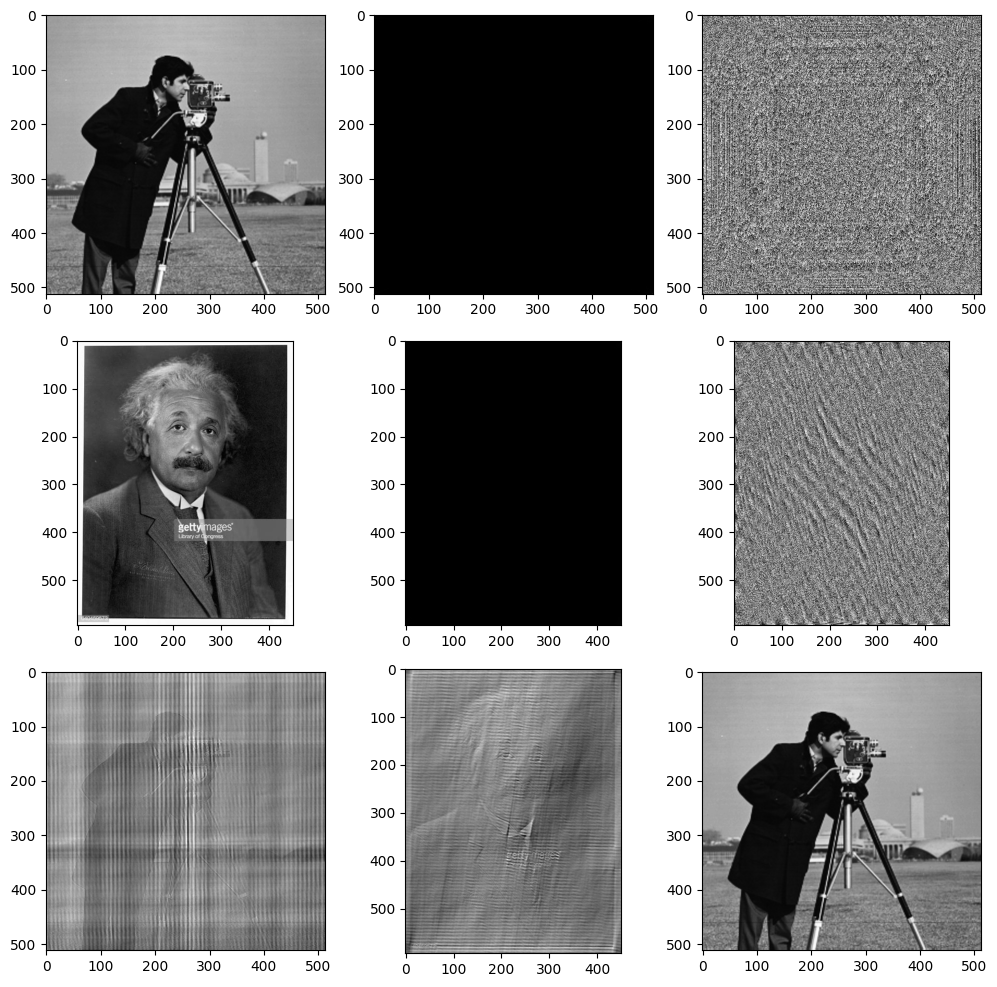

In [28]:
imagenUnoFilename = os.path.join("./imagenes", 'cameraman.jpg')
imagenUno = io.imread(imagenUnoFilename, as_gray=True)

imagenDosFilename = os.path.join("./imagenes", 'einstein.jpg')
imagenDos = io.imread(imagenDosFilename, as_gray=True)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

#imagenUnoModulo, imagenUnoFase = DFT_2D(imagenUno)
trasformadaDeFourire_1 = (np.fft.fft2(imagenUno))

trasformadaDeFourire_2 = (np.fft.fft2(imagenDos))

imagenUnoModulo = np.zeros(trasformadaDeFourire_1.shape)
imagenUnoFase   = np.zeros(trasformadaDeFourire_1.shape)

columna = trasformadaDeFourire_1.shape[0]
fila    = trasformadaDeFourire_1.shape[1]
for i in range(columna):
    for j in range(fila): 
        imagenUnoModulo[i,j] = np.linalg.norm(trasformadaDeFourire_1[i,j]) 
        imagenUnoFase[i,j]   = np.angle(trasformadaDeFourire_1[i,j])

imagenDosModulo = np.zeros(trasformadaDeFourire_2.shape)
imagenDosFase   = np.zeros(trasformadaDeFourire_2.shape)

for i in range(trasformadaDeFourire_2.shape[0]):
    for j in range(trasformadaDeFourire_2.shape[1]): 
        imagenDosModulo[i,j] = np.linalg.norm(trasformadaDeFourire_2[i,j])
        imagenDosFase[i,j]   = np.angle(trasformadaDeFourire_2[i,j])



axes[0][0].imshow(imagenUno, cmap=plt.cm.gray)
axes[0][1].imshow(imagenUnoModulo, cmap=plt.cm.gray)
axes[0][2].imshow(imagenUnoFase, cmap=plt.cm.gray)

axes[1][0].imshow(imagenDos, cmap=plt.cm.gray)
axes[1][1].imshow(imagenDosModulo, cmap=plt.cm.gray)
axes[1][2].imshow(imagenDosFase, cmap=plt.cm.gray)
### COMPLETAR ###
modulo1_fase1 = np.zeros(imagenUno.shape, dtype=np.complex128)

for x in range(imagenUno.shape[0]):
    for y in range(imagenUno.shape[1]):
        modulo = 0
        if(x < imagenDos.shape[0] and y < imagenDos.shape[1]):
            modulo = imagenDosModulo[x,y]

        modulo1_fase1[x,y] = modulo * np.exp(1j*imagenUnoFase[x,y])

modulo1_fase1_ift = np.real(np.fft.ifft2(modulo1_fase1))

modulo1_fase2 = np.zeros(imagenDos.shape, dtype=np.complex128)

for x in range(imagenDos.shape[0]):
    for y in range(imagenDos.shape[1]):
        modulo = 0
        if(x < imagenUno.shape[0] and y < imagenUno.shape[1]):
            modulo = imagenUnoModulo[x,y]

        modulo1_fase2[x,y] = modulo * np.exp(1j*imagenDosFase[x,y])

modulo1_fase2_ift = np.real(np.fft.ifft2(modulo1_fase2))
#modulo2_fase1 = IDFT_2D(imagenDosModulo,imagenUnoFase)

axes[2][0].imshow(modulo1_fase1_ift, cmap=plt.cm.gray)
axes[2][1].imshow(modulo1_fase2_ift, cmap=plt.cm.gray)
axes[2][2].imshow(np.real(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(imagenUno))))), cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

### Componer una imagen con Cameraman y líneas horizontales (sumarlas), y remover las líneas usando la transformada de Fourier.

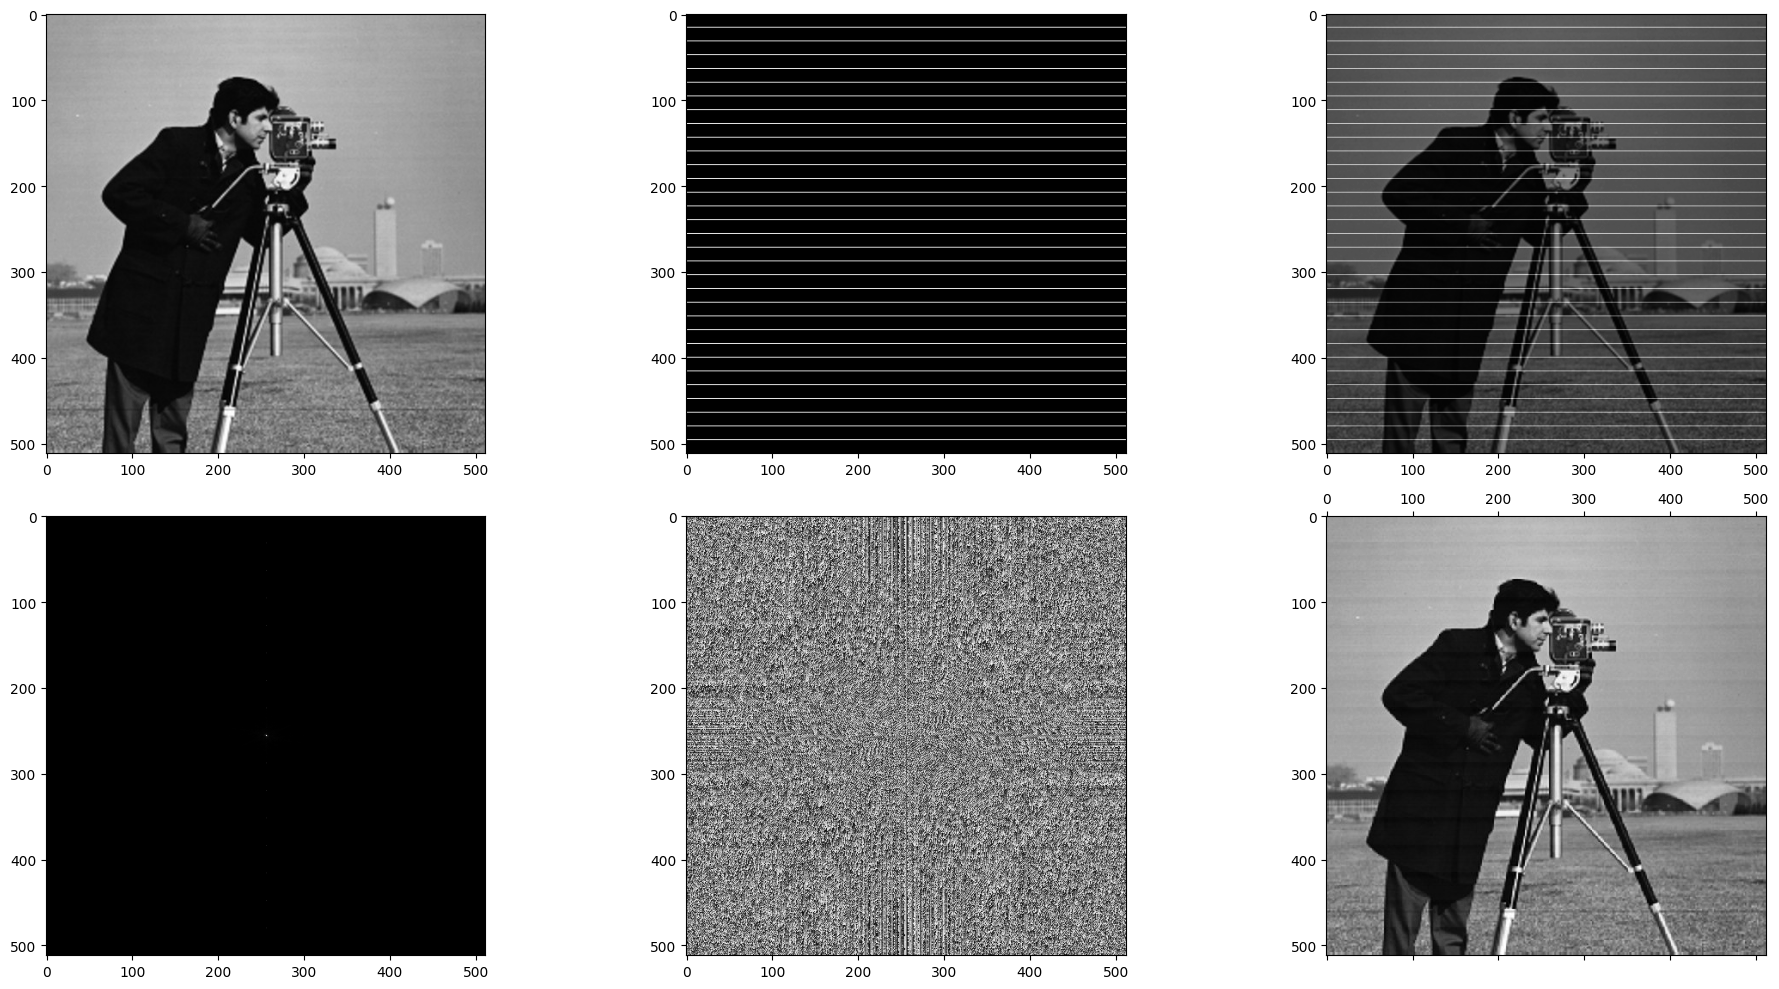

In [119]:
# Abrir la imagen
imagenFilename = os.path.join("./imagenes", 'cameraman.jpg')
imgCameraman = io.imread(imagenFilename, as_gray=True)

# Imagen lineas horizontales

imgLinHorizontales = np.zeros(imgCameraman.shape) 

for i in range(0, imgLinHorizontales.shape[0], 16):
    imgLinHorizontales[i] = np.ones(imgLinHorizontales.shape[1]) * 255

# Agregan las lineas horizontales

imgCompuesta = imgCameraman + imgLinHorizontales

# Realizan la transformacion de Fourier

transFourier = np.fft.fftshift(np.fft.fft2(imgCompuesta))
copiaTransFourier = np.copy(transFourier)

# Analizen las funciones devueltas y piensen si pueden detectar que frecuencia estan asociadas a las lineas
# Eliminen las lineas


for i in range(0, copiaTransFourier.shape[0], 16):
    copiaTransFourier[i][256] = 0

imgRestaurada = np.real(np.fft.ifft2(np.fft.ifftshift(copiaTransFourier)))

# Ploteen el resutado en un subplot de 3, 2. La primer fila mostrando la imagen original, las lineas por separado y la composicion
# La segunda fila mostrando la funcion el plano de modulo, fase y la imagen sin las lineas

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes[0][0].imshow(imgCameraman, cmap=plt.cm.gray)
axes[0][1].imshow(imgLinHorizontales, cmap=plt.cm.gray)
axes[0][2].imshow(imgCompuesta, cmap=plt.cm.gray)
axes[1][0].imshow(np.abs(transFourier), cmap=plt.cm.gray)
axes[1][1].imshow(np.angle(transFourier), cmap=plt.cm.gray)
axes[1][2].matshow(imgRestaurada,cmap=plt.cm.gray)

fig.tight_layout()
plt.show()
